In [ ]:

!pip install mediapipe==0.10.7


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install opencv-python scikit-learn matplotlib --quiet

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:18<00:00, 61.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1"

for item in os.listdir(dataset_path):
    print(item)


asl_alphabet_test
asl_alphabet_train


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/"

# Preprocess: normalize and augment slightly
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)


img_size = (64, 64)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

labels = list(train_generator.class_indices.keys())


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',  # <- CHANGED
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',  # <- CHANGED
    subset='validation'
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # 29 = 26 letters + other signs like space, nothing, etc.
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 544s 249ms/step - accuracy: 0.4361 - loss: 1.8776 - val_accuracy: 0.7449 - val_loss: 0.8929
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 538s 248ms/step - accuracy: 0.8933 - loss: 0.3129 - val_accuracy: 0.8020 - val_loss: 0.8083
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 540s 248ms/step - accuracy: 0.9428 - loss: 0.1661 - val_accuracy: 0.8152 - val_loss: 0.7740
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 559s 247ms/step - accuracy: 0.9612 - loss: 0.1137 - val_accuracy: 0.8202 - val_loss: 0.7855
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 539s 248ms/step - accuracy: 0.9717 - loss: 0.0856 - val_accuracy: 0.8167 - val_loss: 0.7580


In [ ]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.2f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.8190 - loss: 0.7597
Validation Accuracy: 0.82


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import numpy as np
import PIL.Image
import io

# JavaScript code to capture image
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize video
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for capture
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getVideoTracks()[0].stop();
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    with open(filename, 'wb') as f:
        f.write(binary.getbuffer())
    return filename


<IPython.core.display.Javascript object>

Image saved to photo.jpg


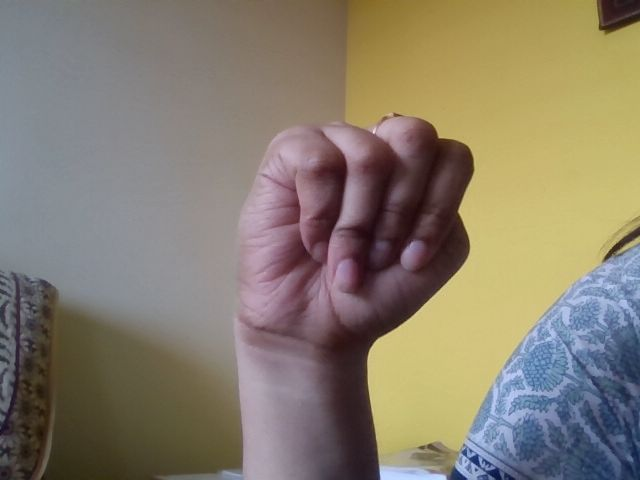

In [ ]:
import base64

filename = take_photo()
print(f"Image saved to {filename}")

# Display the image
import IPython.display as display
display.display(PIL.Image.open(filename))


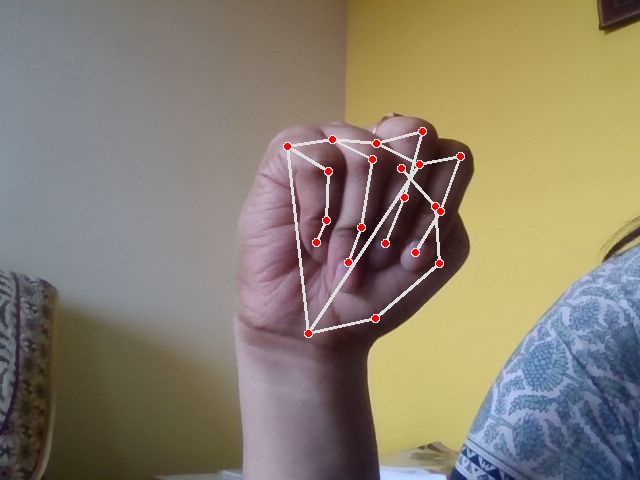

In [ ]:
import mediapipe as mp

image = cv2.imread(filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Show annotated image
cv2.imwrite('hand_detected.jpg', image)
display.display(PIL.Image.open('hand_detected.jpg'))


In [ ]:
import cv2
import numpy as np

img_path = "/content/photo.jpg"

img = cv2.imread(img_path)
img = cv2.resize(img, img_size)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
predicted_label = labels[np.argmax(pred)]

print("Predicted Sign Language Letter:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Sign Language Letter: M


In [ ]:
import time
import collections

# For webcam capture and prediction loop
def predict_live_word(model, labels, img_size, max_frames=50, delay=1.0):
    from IPython.display import clear_output, display
    import cv2
    import numpy as np
    import PIL.Image
    import base64
    import io
    from google.colab.output import eval_js
    from IPython.display import Javascript

    def take_photo_js():
        js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
        display(js)
        return eval_js('takePhoto(0.8)')

    current_word = ""
    predicted_sentence = []

    for i in range(max_frames):
        print(f"\nFrame {i+1}/{max_frames} - Show a gesture now:")
        data_uri = take_photo_js()
        binary = io.BytesIO(base64.b64decode(data_uri.split(',')[1]))

        img = cv2.imdecode(np.frombuffer(binary.read(), np.uint8), cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)

        pred = model.predict(img)
        pred_label = labels[np.argmax(pred)]

        print("Predicted:", pred_label)

        # Update current word
        if pred_label == "space":
            if current_word:
                predicted_sentence.append(current_word)
                current_word = ""
        elif pred_label == "del":
            current_word = current_word[:-1]
        elif pred_label == "nothing":
            pass  # do nothing
        else:
            current_word += pred_label.upper()

        print("Current Word:", current_word)
        print("Predicted Sentence:", " ".join(predicted_sentence))
        time.sleep(delay)

    if current_word:
        predicted_sentence.append(current_word)

    print("\n✅ Final Sentence:", " ".join(predicted_sentence))


In [ ]:
predict_live_word(model, labels, img_size, max_frames=5, delay=2.0)


Frame 1/5 - Show a gesture now:


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: W
Current Word: W
Predicted Sentence: 

Frame 2/5 - Show a gesture now:


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: S
Current Word: WS
Predicted Sentence: 

Frame 3/5 - Show a gesture now:


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: X
Current Word: WSX
Predicted Sentence: 

Frame 4/5 - Show a gesture now:


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: N
Current Word: WSXN
Predicted Sentence: 

Frame 5/5 - Show a gesture now:


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: O
Current Word: WSXNO
Predicted Sentence: 

✅ Final Sentence: WSXNO
